In [1]:
# Import dependencies
import os
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
# from config import username, password
import time
from pathlib import Path

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble.forest import RandomForestClassifier

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns
from collections import Counter

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

C:\Users\Rob\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Import the data
file_path = "Resources/Cleaned_Accidents_Data.csv"
cleaned_df = pd.read_csv(file_path)
cleaned_df.head()

,Severity,Latitude,Longitude,State,Zipcode,Country,Temperature_F,Visibility_miles,Wind_Speed_mph,Precipitation_inches,...,Roundabout,Stop_Sign,Traffic,Traffic_Light,Turning_Loop,Year,Month,Time,Part_of_Week,Time_of_Day
0,3,39.865147,-84.058723,OH,45424,US,36.9,10.0,0.0,0.02,...,False,False,False,False,False,2016,February,5,Weekday,Early Morning
1,2,39.928059,-82.831184,OH,43068,US,37.9,10.0,0.0,0.00,...,False,False,False,False,False,2016,February,6,Weekday,Early Morning
2,2,39.063148,-84.032608,OH,45176,US,36.0,10.0,3.5,0.00,...,False,False,False,True,False,2016,February,6,Weekday,Early Morning
3,3,39.747753,-84.205582,OH,45417,US,35.1,9.0,4.6,0.00,...,False,False,False,False,False,2016,February,7,Weekday,Early Morning
4,2,39.627781,-84.188354,OH,45459,US,36.0,6.0,3.5,0.00,...,False,False,False,True,False,2016,February,7,Weekday,Early Morning


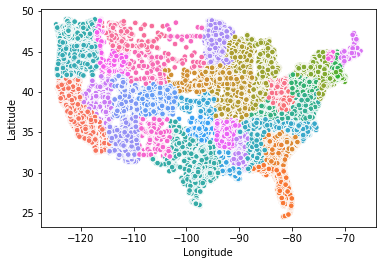

In [3]:
# Map of accidents, color code by State
sns.scatterplot(x='Longitude', y='Latitude', data=cleaned_df, hue='State', legend=False, s=30)
plt.show()

In [4]:
filtered_cleaned_df = cleaned_df.drop(['Country'], axis=1)

In [5]:
# Define target vector
X = filtered_cleaned_df.copy()
X = filtered_cleaned_df.drop('Severity', axis=1)
y = filtered_cleaned_df['Severity'].values.reshape(-1, 1)
y[:5]

array([[3],
       [2],
       [2],
       [3],
       [2]], dtype=int64)

In [6]:
X.head()

,Latitude,Longitude,State,Zipcode,Temperature_F,Visibility_miles,Wind_Speed_mph,Precipitation_inches,Weather_Condition,Speed_Bump,...,Roundabout,Stop_Sign,Traffic,Traffic_Light,Turning_Loop,Year,Month,Time,Part_of_Week,Time_of_Day
0,39.865147,-84.058723,OH,45424,36.9,10.0,0.0,0.02,Light Rain,False,...,False,False,False,False,False,2016,February,5,Weekday,Early Morning
1,39.928059,-82.831184,OH,43068,37.9,10.0,0.0,0.00,Light Rain,False,...,False,False,False,False,False,2016,February,6,Weekday,Early Morning
2,39.063148,-84.032608,OH,45176,36.0,10.0,3.5,0.00,Overcast,False,...,False,False,False,True,False,2016,February,6,Weekday,Early Morning
3,39.747753,-84.205582,OH,45417,35.1,9.0,4.6,0.00,Mostly Cloudy,False,...,False,False,False,False,False,2016,February,7,Weekday,Early Morning
4,39.627781,-84.188354,OH,45459,36.0,6.0,3.5,0.00,Mostly Cloudy,False,...,False,False,False,True,False,2016,February,7,Weekday,Early Morning


In [7]:
X = pd.get_dummies(data=X, columns=['Time_of_Day', 
                                    'Part_of_Week',
                                    'Month',
                                    'Turning_Loop',
                                    'Traffic_Light',
                                    'Traffic',
                                    'Stop_Sign',
                                    'Roundabout',
                                    'Year',
                                    'Weather_Condition',
                                    'State', 
                                    'Cross_Walk', 
                                    'Speed_Bump', 
                                    'Yield_Sign', 
                                    'Intersection', 
                                    'Railway', 
                                    'No_Exit'])

X = X.dropna()
X.head()

,Latitude,Longitude,Zipcode,Temperature_F,Visibility_miles,Wind_Speed_mph,Precipitation_inches,Time,Time_of_Day_Afteroon,Time_of_Day_Early Morning,...,Speed_Bump_False,Speed_Bump_True,Yield_Sign_False,Yield_Sign_True,Intersection_False,Intersection_True,Railway_False,Railway_True,No_Exit_False,No_Exit_True
0,39.865147,-84.058723,45424,36.9,10.0,0.0,0.02,5,0,1,...,1,0,1,0,1,0,1,0,1,0
1,39.928059,-82.831184,43068,37.9,10.0,0.0,0.00,6,0,1,...,1,0,1,0,1,0,1,0,1,0
2,39.063148,-84.032608,45176,36.0,10.0,3.5,0.00,6,0,1,...,1,0,1,0,1,0,1,0,1,0
3,39.747753,-84.205582,45417,35.1,9.0,4.6,0.00,7,0,1,...,1,0,1,0,1,0,1,0,1,0
4,39.627781,-84.188354,45459,36.0,6.0,3.5,0.00,7,0,1,...,1,0,1,0,1,0,1,0,1,0


In [8]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2569176, 229)
(856392, 229)
(2569176, 1)
(856392, 1)


In [10]:
# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [11]:
# Create a random forest classifier.
rf_model = RandomForestClassifier()
rf_model = RandomForestClassifier(n_estimators=100, random_state=78, verbose=3, max_depth = 6) 

In [12]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

C:\Users\Rob\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.9min finished


In [13]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)
predictions

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.9s finished


array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [27]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 1", "Actual 2", "Actual 3", "Actual 4"], columns=["Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4"])

cm_df

,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 1,0,7208,0,0
Actual 2,0,579374,97,0
Actual 3,0,242119,601,0
Actual 4,0,26927,66,0


In [28]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)

In [22]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score: {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 1,0,7208,0,0
Actual 2,0,579374,97,0
Actual 3,0,242119,601,0
Actual 4,0,26927,66,0


Accuracy Score: 0.6772307541406272
Classification Report


C:\Users\Rob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      7208
           2       0.68      1.00      0.81    579471
           3       0.79      0.00      0.00    242720
           4       0.00      0.00      0.00     26993

    accuracy                           0.68    856392
   macro avg       0.37      0.25      0.20    856392
weighted avg       0.68      0.68      0.55    856392



In [23]:
# Print the feature importances from the Random Forest classifier
feature_names = X.columns
sorted(zip(rf_model.feature_importances_, feature_names), reverse=True)

[(0.19858343645241283, 'Traffic_Light_True'),
 (0.13438001450867212, 'Traffic_Light_False'),
 (0.0739204551579116, 'Cross_Walk_False'),
 (0.0720432018781853, 'Cross_Walk_True'),
 (0.0689913997994388, 'Part_of_Week_Weekend'),
 (0.06187701662614832, 'Zipcode'),
 (0.044005584133686534, 'Longitude'),
 (0.042887266108375774, 'Part_of_Week_Weekday'),
 (0.02564166666969964, 'Latitude'),
 (0.02160604621872713, 'State_GA'),
 (0.02150066579894482, 'Weather_Condition_Fair'),
 (0.02133773149118596, 'Year_2020'),
 (0.021009576847758882, 'State_NC'),
 (0.016660117915796732, 'State_OR'),
 (0.013611650990959115, 'Stop_Sign_False'),
 (0.012457149569837189, 'Intersection_True'),
 (0.012185446652173441, 'Stop_Sign_True'),
 (0.010656829428067815, 'Year_2018'),
 (0.010312209287503052, 'State_CA'),
 (0.009065065493650284, 'Time'),
 (0.008263106063424418, 'State_SC'),
 (0.00804214751749364, 'Year_2019'),
 (0.007882725498222498, 'Intersection_False'),
 (0.00695551190740689, 'State_MO'),
 (0.005370156206006549

In [24]:
rf_model.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.5s finished


0.6766422386010145

No handles with labels found to put in legend.


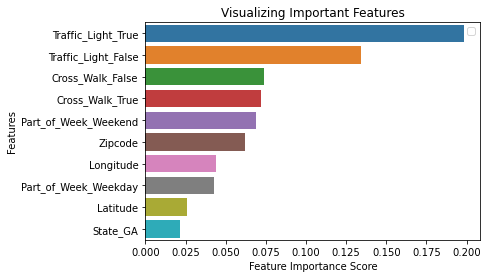

In [25]:
rf_features = pd.Series(rf_model.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=rf_features[:10], y=rf_features.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()